In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import  EarlyStopping,CSVLogger,ReduceLROnPlateau
from glob import glob
import cv2
import random
from sklearn.model_selection import train_test_split
import json
import xml.etree.ElementTree as ET

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
file = 'ibug300/labels_ibug_300W_train.xml'

In [4]:
with open(file, 'r') as file:
    xml_content = file.read()

In [5]:
root = ET.fromstring(xml_content)

# Check if the root element is read correctly
print(f"Root tag: {root.tag}")

# Check all direct children of the root element
for child in root:
    print(f"Child tag: {child.tag}")

Root tag: dataset
Child tag: name
Child tag: comment
Child tag: images


In [6]:
def parse_image(image_element):
    image_info = {
        'file': image_element.get('file'),
        'width': int(image_element.get('width')),
        'height': int(image_element.get('height')),
        'boxes': []
    }
    for box in image_element.findall('box'):
        box_top = int(box.get('top'))
        box_left = int(box.get('left'))
        box_info = {
            'top': int(box.get('top')),
            'left': int(box.get('left')),
            'width': int(box.get('width')),
            'height': int(box.get('height')),
            'parts': []
        }
        for part in box.findall('part'):
            part_info = {
                'name': part.get('name'),
                'x': int(part.get('x')),
                'y': int(part.get('y'))
            }
            box_info['parts'].append(part_info)
        image_info['boxes'].append(box_info)
    return image_info

In [7]:
images_data = [parse_image(image) for image in root.findall('images')[0].findall('image')]

In [8]:
images_data

[{'file': 'lfpw/trainset/image_0457.png',
  'width': 350,
  'height': 464,
  'boxes': [{'top': 78,
    'left': 74,
    'width': 138,
    'height': 140,
    'parts': [{'name': '00', 'x': 55, 'y': 141},
     {'name': '01', 'x': 59, 'y': 161},
     {'name': '02', 'x': 66, 'y': 182},
     {'name': '03', 'x': 75, 'y': 197},
     {'name': '04', 'x': 90, 'y': 209},
     {'name': '05', 'x': 108, 'y': 220},
     {'name': '06', 'x': 131, 'y': 226},
     {'name': '07', 'x': 149, 'y': 232},
     {'name': '08', 'x': 167, 'y': 230},
     {'name': '09', 'x': 181, 'y': 225},
     {'name': '10', 'x': 184, 'y': 208},
     {'name': '11', 'x': 186, 'y': 193},
     {'name': '12', 'x': 185, 'y': 179},
     {'name': '13', 'x': 184, 'y': 167},
     {'name': '14', 'x': 186, 'y': 152},
     {'name': '15', 'x': 185, 'y': 142},
     {'name': '16', 'x': 181, 'y': 133},
     {'name': '17', 'x': 95, 'y': 128},
     {'name': '18', 'x': 105, 'y': 121},
     {'name': '19', 'x': 117, 'y': 117},
     {'name': '20', 'x': 

In [9]:
len(images_data)

6666

In [10]:
image_dir ='ibug300'

In [13]:
def load_image(image_info):
    try:
        image_path = os.path.join(image_dir, image_info['file'])
        image = cv2.imread(image_path)
        # if image is None:
        #     raise ValueError(f"Image {image_info['file']} not found")

        h, w, _ = image.shape

        data = []
        box = image_info['boxes'][0]
        top, left, width, height = box['top'], box['left'], box['width'], box['height']

        image = cv2.resize(image, (224, 224))

        for part in box['parts']:
            part_name = part['name']
            x, y = part['x'], part['y']

            data.append(np.array([x, y]))
    except ValueError as e:
       print(f"Image {image_info['file']} not found")
       print(e)
       return None , None


    return image , np.array(data)

In [14]:
image , data = load_image(images_data[55])

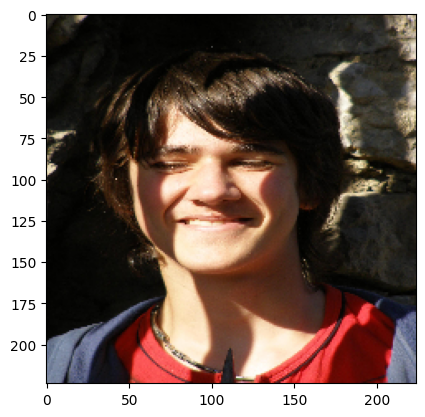

In [17]:
image =  cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
for j in range(68):
    cv2.circle(image,(int(data[j][0]),int(data[j][1])),2,255,-1)

plt.imshow(image)

In [18]:
def load_data(images_data):
    images = []
    labels = []
    j = 0
    for i in images_data:
        try:
            image , data = load_image(i)
            images.append(image)
            labels.append(data)
            print(i['file'])
            print(j)
            j += 1
        except ValueError as e:
            print(e)

    for i in range(len(images)):
        if images[i] is None:
            images.pop(i)
            labels.pop(i)

    return np.array(images), np.array(labels)

In [ ]:
images , labels = load_data(images_data[:100])

In [ ]:
fig = plt.figure(figsize=(15, 6))

for n , i in enumerate(list(np.random.randint(0 ,images.shape[0],10))):
    plt.subplot(2,5,n+1)
    image = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    y = labels[i]
    for j in range(68):
        cv2.circle(image,(int(y[j][0]),int(y[j][1])),2,255,-1)

    plt.imshow(image)
    plt.axis('off')

In [ ]:
labels = labels.reshape(-1,68 * 2)
images = images.astype('float32') / 255.0

In [ ]:
print(images.shape)
print(labels.shape)

(6666, 224, 224, 3)
(6666, 136)


In [ ]:
mobile_net = MobileNetV2(include_top=False,weights='imagenet' ,input_shape=(224,224,3))

In [ ]:
for layer in mobile_net.layers:
  layer.trainable = False

for layer in mobile_net.layers[-3:]:
    layer.trainable = True

In [ ]:
landmark_model = tf.keras.models.Sequential([mobile_net,
                                             tf.keras.layers.GlobalAveragePooling2D(),
                                             tf.keras.layers.Dense(68 * 2,activation = "sigmoid")])

In [ ]:
landmark_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 136)               174216    
                                                                 
Total params: 2432200 (9.28 MB)
Trainable params: 586376 (2.24 MB)
Non-trainable params: 1845824 (7.04 MB)
_________________________________________________________________


In [ ]:
gc.collect()

6190

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003)
landmark_model.compile(optimizer=optimizer,
                        loss= tf.keras.losses.MAE)

In [ ]:
csv_path = '/content/drive/MyDrive/data_hubber_ibug.csv'

In [ ]:
callbacks = [
        CSVLogger(csv_path, append=True),
        EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=False)
    ]

In [ ]:
history = landmark_model.fit(
    images,labels,epochs=100,
    batch_size=32,validation_split = 0.2,
    callbacks=callbacks)

Epoch 1/100
167/167 [==============================] - 10s 43ms/step - loss: 0.1082 - val_loss: 0.1123
Epoch 2/100
167/167 [==============================] - 6s 33ms/step - loss: 0.0826 - val_loss: 0.1002
Epoch 3/100
167/167 [==============================] - 6s 33ms/step - loss: 0.0732 - val_loss: 0.0929
Epoch 4/100
167/167 [==============================] - 6s 34ms/step - loss: 0.0682 - val_loss: 0.0837
Epoch 5/100
167/167 [==============================] - 6s 33ms/step - loss: 0.0641 - val_loss: 0.0788
Epoch 6/100
167/167 [==============================] - 6s 34ms/step - loss: 0.0614 - val_loss: 0.0774
Epoch 7/100
167/167 [==============================] - 6s 34ms/step - loss: 0.0592 - val_loss: 0.0777
Epoch 8/100
167/167 [==============================] - 6s 33ms/step - loss: 0.0568 - val_loss: 0.0730
Epoch 9/100
167/167 [==============================] - 6s 33ms/step - loss: 0.0553 - val_loss: 0.0739
Epoch 10/100
167/167 [==============================] - 6s 33ms/step - loss: 0.05

In [ ]:
landmark_model.save('landmark_mae_ibug.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
landmark_model.save('landmark_mae_ibug.keras')

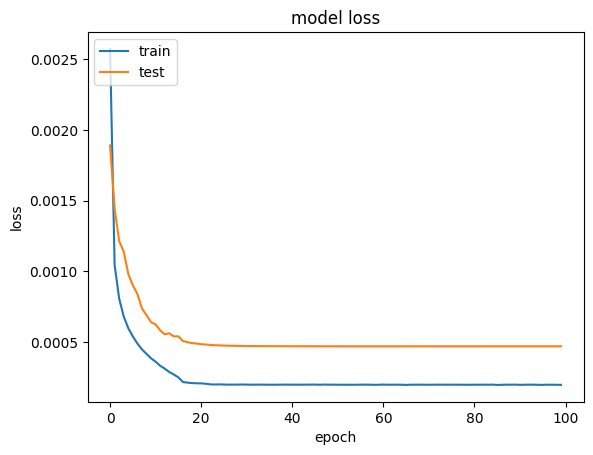

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()